# Steam平台游戏数据分析

## 作者

* 190207132 单元琛
    - 数据搜索、数据处理、可视化分析、报告整理
* 190207029 陈凯
    - 海报制作、报告整理

## 问题描述

通过研究近年来Steam中游戏的价格和日期、评价等因素，
并进行可视化处理，从而得出不同价格区间游戏的一些共性及特性

## 数据来源

[kaggle - Steam games complete dataset](https://www.kaggle.com/trolukovich/steam-games-complete-dataset)

## 数据处理

In [1]:
# 导入需要的库
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 增加中文显示
plt.rcParams['font.sans-serif'].insert(0, 'Microsoft YaHei')

In [3]:
# 读取数据
df = pd.read_csv('..\data\steam_games.csv')
df = df[df.types == 'app']

In [4]:
# 数据切片
df = df[['name','all_reviews','release_date',
         'publisher','genre','original_price',
         'game_description']]
df

,name,all_reviews,release_date,publisher,genre,original_price,game_description
0,DOOM,"Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016","Bethesda Softworks,Bethesda Softworks",Action,$19.99,"About This Game Developed by id software, the..."
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017","PUBG Corporation,PUBG Corporation","Action,Adventure,Massively Multiplayer",$29.99,About This Game PLAYERUNKNOWN'S BATTLEGROUND...
2,BATTLETECH,"Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018","Paradox Interactive,Paradox Interactive","Action,Adventure,Strategy",$39.99,About This Game From original BATTLETECH/Mec...
3,DayZ,"Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018","Bohemia Interactive,Bohemia Interactive","Action,Adventure,Massively Multiplayer",$44.99,About This Game The post-soviet country of Ch...
4,EVE Online,"Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003","CCP,CCP","Action,Free to Play,Massively Multiplayer,RPG,...",Free,About This Game
...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,NaN,"Feb 12, 2019",NaN,"Casual,Simulation",$2.99,"About This Content Play ""Ghost Division"" by S..."
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,NaN,"Feb 5, 2019",NaN,"Casual,Simulation",$2.99,"About This Content Play ""Trippin’ on a Hole i..."
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,NaN,"Jul 31, 2018",NaN,"Indie,RPG,Strategy",$7.99,About This Content Quests of Doom 4: A Midni...
40831,Mega Man X5 Sound Collection,NaN,"Jul 24, 2018","CAPCOM CO., LTD,CAPCOM CO., LTD",Action,$9.99,About This Content Get equipped with the stun...


In [5]:
# 数据信息统计
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38021 entries, 0 to 40832
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              38007 non-null  object
 1   all_reviews       28470 non-null  object
 2   release_date      37654 non-null  object
 3   publisher         33021 non-null  object
 4   genre             37625 non-null  object
 5   original_price    34999 non-null  object
 6   game_description  37920 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB


### 进行数据整理和填充

In [6]:
# 对价格填充
df.original_price.fillna(0, inplace=True)

# 对日期填充
df.release_date.fillna(method='bfill', inplace=True)

In [7]:
# 对日期处理
month_dic = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,
         'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,
         'Nov':11,'Dec':12}

def change_date(arr):
    try:
        result = re.findall('\w+',arr)
        month = int(month_dic[result[0]])
        day = int(result[1])
        year = int(result[2])
        return datetime.date(year,month,day)
    except (TypeError, KeyError, IndexError, ValueError):
        pass

df['release_date'] = df['release_date'].map(change_date)
df.release_date.fillna(method='bfill', inplace=True)

In [8]:
# 生成游戏发售年份和月份
def gen_year(arr):
    return arr.year

def gen_month(arr):
    return arr.month

df['year'] = df['release_date'].map(gen_year)
df['month'] = df['release_date'].map(gen_month)

In [9]:
# 对价格进行处理
def change_price(arr):
    try:
        if re.match('\$.+', arr):
            return float(arr[1:])
        else:
            return 0
    except TypeError:
        return 0

df['original_price'] = df['original_price'].map(change_price)

In [10]:
# 对评论进行处理
def change_review(arr):
    try:
        match_obj = re.search(',- \d+%', arr)
        return int(match_obj.group(0)[2:-1]) / 100.0
    except (TypeError, AttributeError):
        return np.random.randint(10, 80) / 100.0

df['all_reviews'] = df['all_reviews'].map(change_review)
df.all_reviews.fillna(method='pad', inplace=True)

In [11]:
# 对数据进行清洗
df.fillna('Unknown', inplace=True)
df = df[~df['name'].isin(['Unknown'])]
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38006 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              38006 non-null  object 
 1   all_reviews       38006 non-null  float64
 2   release_date      38006 non-null  object 
 3   publisher         38006 non-null  object 
 4   genre             38006 non-null  object 
 5   original_price    38006 non-null  float64
 6   game_description  38006 non-null  object 
 7   year              38006 non-null  int64  
 8   month             38006 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.9+ MB


In [12]:
# 更改列名
df.columns = ['Name', 'Review', 'Date', 'Publisher',
              'Genre', 'Price', 'Description', 'Year', 'Month']

In [13]:
# 对价格分类
def sort_price(arr):
    if arr == 0:
        return 'Free'
    elif arr <= 10:
        return '0\$ - 10\$'
    elif arr <= 20:
        return '10\$ - 20\$'
    else:
        return '30$+'
df['price_category'] = df['Price'].map(sort_price)

<ipython-input-13-5868b82e8a3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_category'] = df['Price'].map(sort_price)


In [14]:
# 明确游戏分类
def sort_genre(arr):
    genre = re.search('\w+',arr)
    return genre[0]
df['Genre'] = df['Genre'].map(sort_genre)

<ipython-input-14-429d0a87bf6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre'] = df['Genre'].map(sort_genre)


### 对游戏介绍进行NLP，做出词云图

In [15]:
tmp = []
for word in df.Description:
    tmp.append(word)
desc = ' '.join(str(i) for i in tmp)

In [16]:
from wordcloud import WordCloud, STOPWORDS

stp = set(STOPWORDS)
stp.update({'player','players','Feature','Content','Features',
            'different','gameplay'})
background_image = np.array(Image.open('../data/bg.jpg'))
word_cloud = WordCloud(stopwords=stp,
                       collocations=False,
                       background_color='white',
                       min_word_length=6,
                       mask=background_image,
                       scale=2
                       ).generate_from_text(desc)

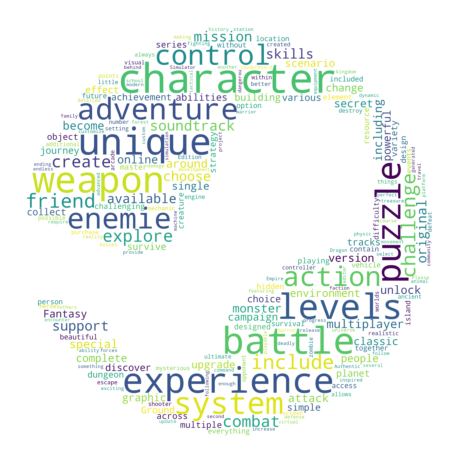

In [17]:
# word_cloud.to_file('../data/out.jpg')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
# 按价格分成四类
df_1 = df[df.Price == 0] # 免费游戏
df_2 = df[(df.Price > 0) & (df.Price <= 10)] # 10美元以内
df_3 = df[(df.Price > 10) & (df.Price <= 20)] # 10-20
df_4 = df[df.Price > 20] # 20+

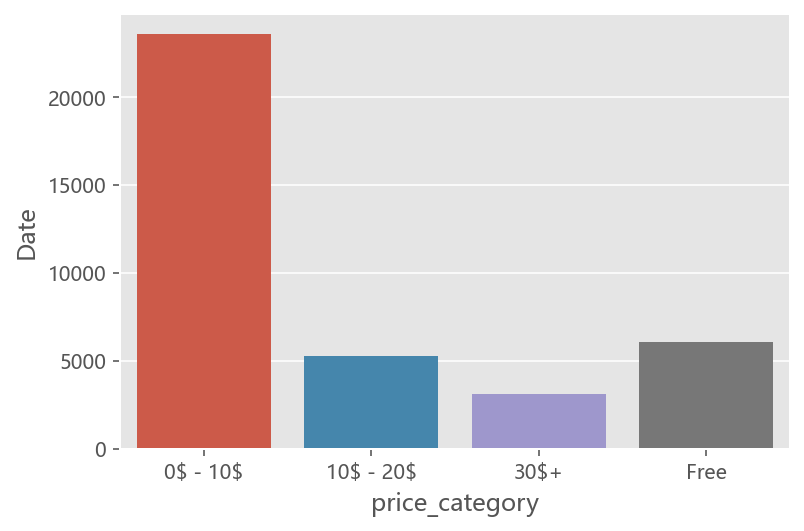

In [19]:
plt.style.use('ggplot')
four_price = df.pivot_table(index='price_category',
                            aggfunc='count').reset_index()
sns.barplot(data=four_price,x='price_category',y='Date')
plt.ylabel(' ')

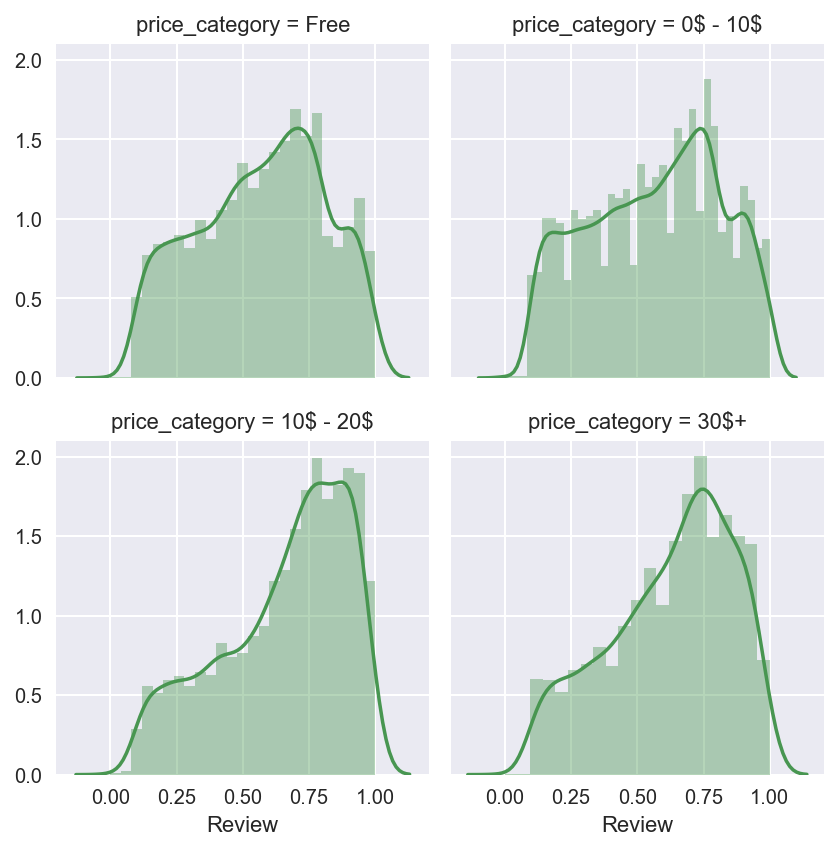

In [20]:
# 四类游戏里好评度直方图及回归曲线
plt.style.use('seaborn')
g = sns.FacetGrid(df,col='price_category',col_wrap=2,
                  col_order=['Free','0\$ - 10\$',
                             '10\$ - 20\$','30$+'])
g = g.map(sns.distplot, 'Review', color='#489651')

Text(0, 0.5, ' ')

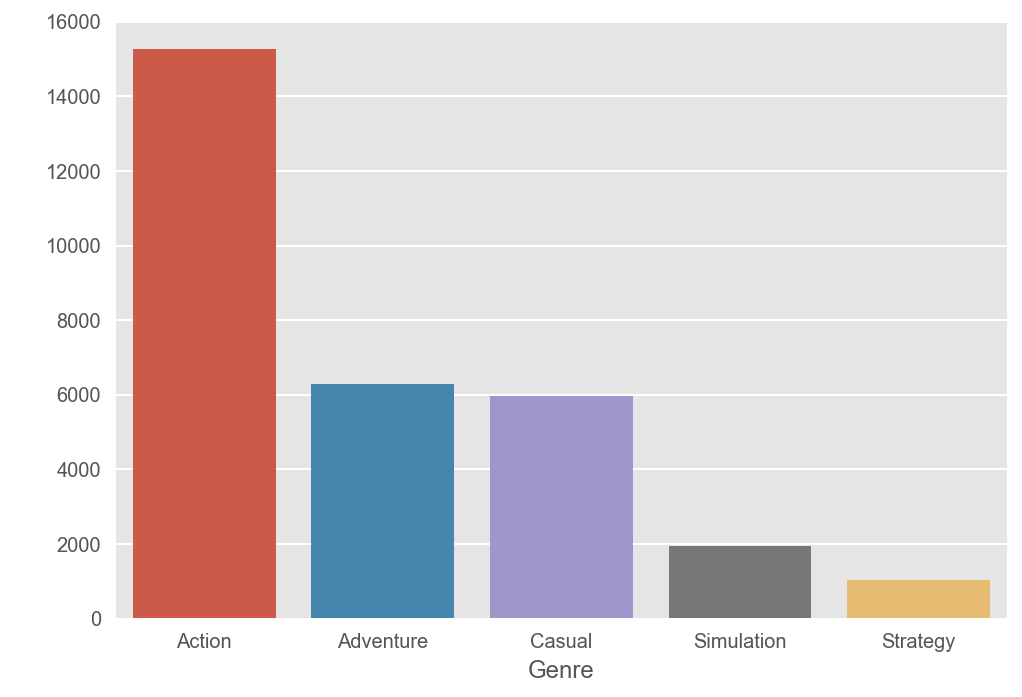

In [26]:
plt.style.use('ggplot')
genres = df.pivot_table(index='Genre',aggfunc='count')
genres = genres.sort_values('Date',ascending=False).reset_index()
genres = genres.drop(index=[3,7,8])[:5]
sns.barplot(data=genres,x='Genre',y='Date')
plt.ylabel(' ')

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 7 Text major ticklabel objects>)

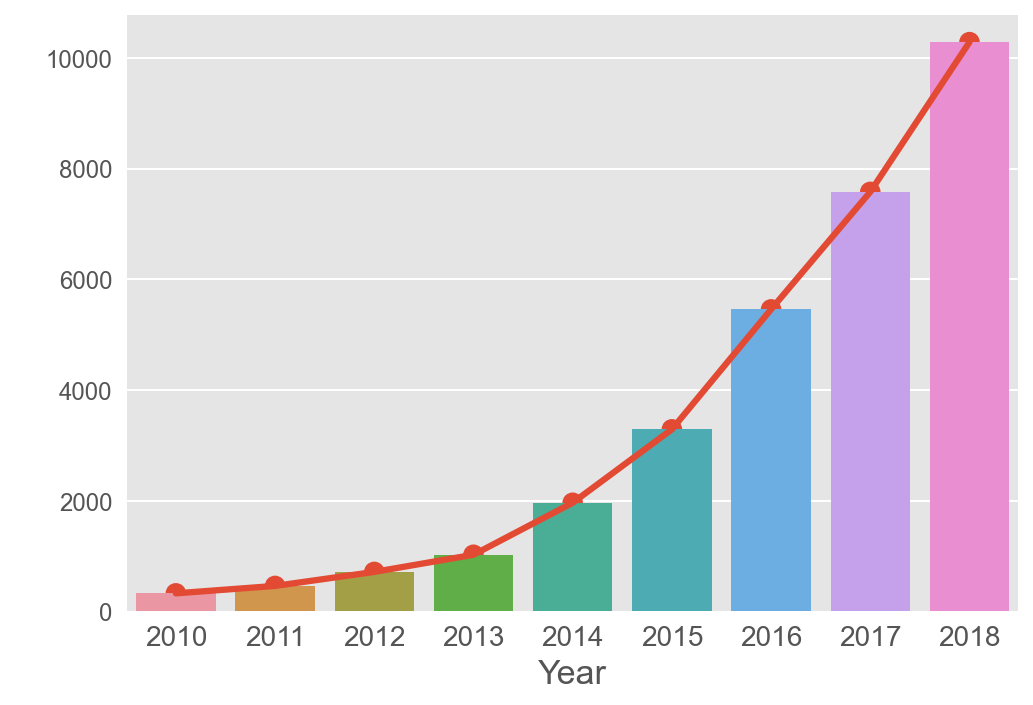

In [22]:
# 游戏数量变化趋势
year_pivot = df[(df.Year > 2009) & (df.Year < 2019)].pivot_table(index='Year',aggfunc='count')
year_pivot.reset_index()
sns.barplot(data=year_pivot,x=year_pivot.index,y=year_pivot.Date)
sns.pointplot(data=year_pivot,x=year_pivot.index,y=year_pivot.Date)
plt.ylabel(' ')
plt.xlabel('Year',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

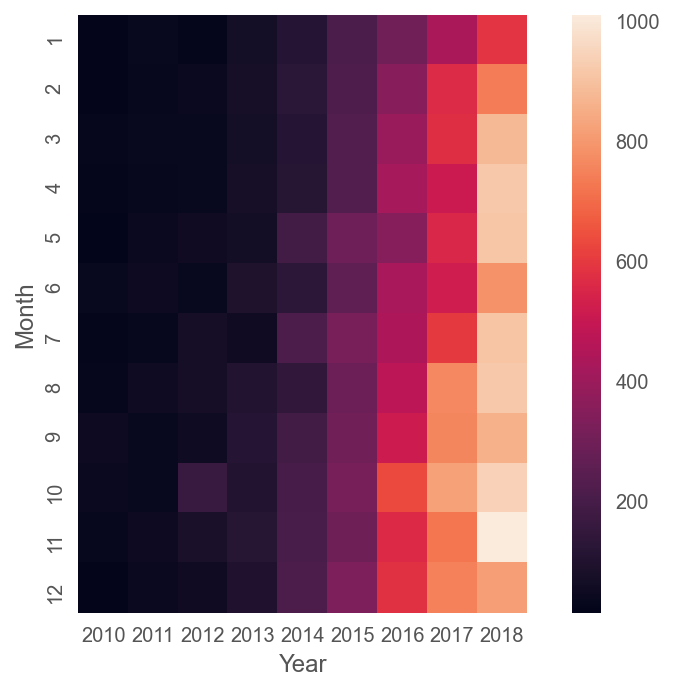

In [23]:
# 游戏发售时间热力图
plt.style.use('ggplot')
pivot = df[(df.Year > 2009) & (df.Year < 2019)].pivot_table(
        index='Month',columns='Year',
        aggfunc='count',values='Review')
sns.heatmap(pivot,square=True)

Text(0.5, 0, 'Games')

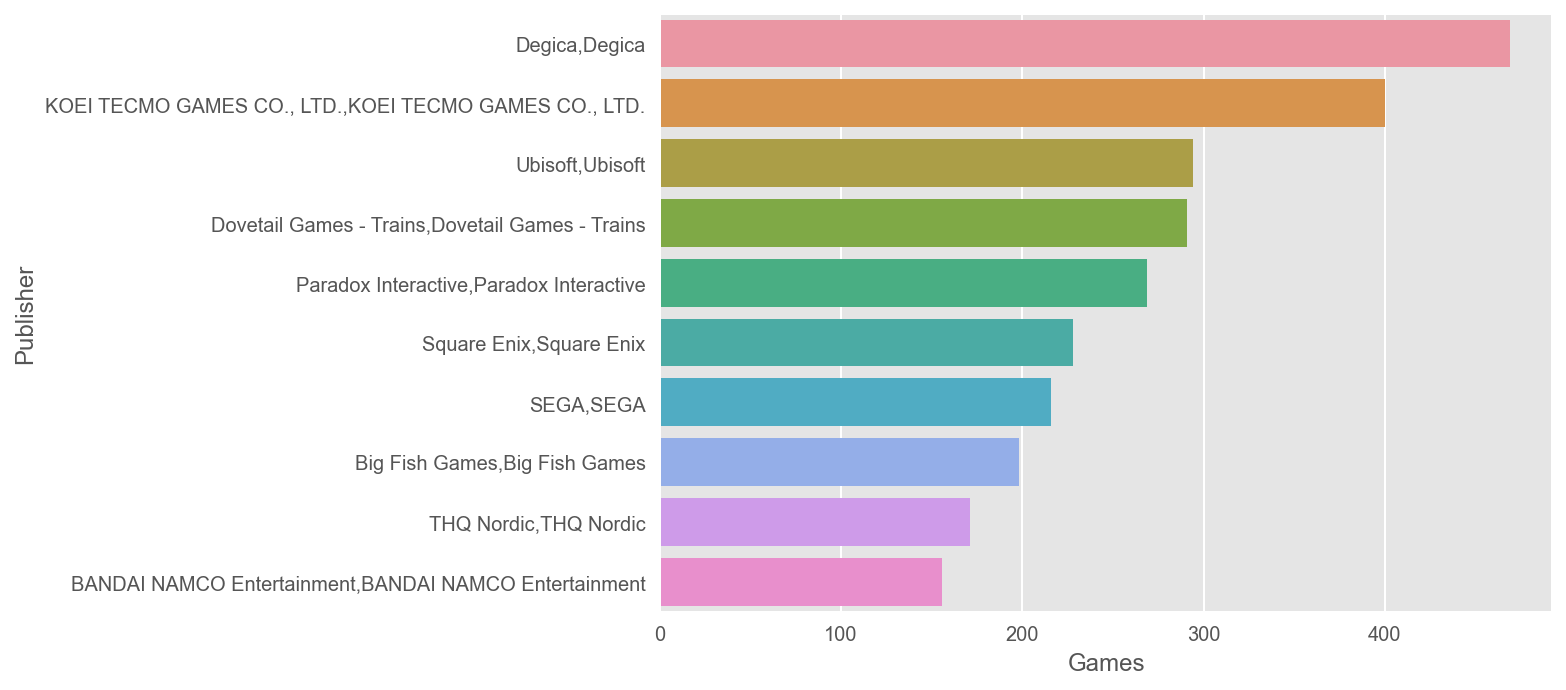

In [25]:
# 对发行商进行数据分析，统计出哪些开发商更高产

def change_publisher(arr):
    return re.split(r',',arr)

pub = df.groupby('Publisher').count().sort_values(by='Review',ascending=False)
top_10 = pub.Name[1:11].reset_index()
top_10.Publisher.map(change_publisher)
# top_10.Publisher[1] = 'KOEI TECMO GAMES'
# top_10.Publisher[2] = 'Ubisoft'
# top_10.Publisher[3] = 'Dovetail Games'
# top_10.Publisher[4] = 'Paradox Interactive'
# top_10.Publisher[9] = 'BANDAI NAMCO'
sns.barplot(y=top_10.Publisher,x=top_10.Name)
plt.xlabel('Games')
